# Classify data w/ Keras
https://keras.io/examples/nlp/text_classification_with_transformer/

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from keras.optimizers import SGD

from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

In [2]:
# load pre-processed data
train_df, test_df, test_df_truncated, solution_df_truncated, desired_class, desired_ID, text_train_arrays, text_test_arrays = pickle.load( open( "cleaned_train.pkl", "rb" ) )


In [31]:
# 1. Transform categorical labels to numerical labels between 0 and len(labels) using labelEncoder
# 2. one hot encode our label
y_train = train_df.Class
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train_hot = np_utils.to_categorical(label_encoder.transform(y_train))

# target labels
y_true = [int(x) for x in desired_class.ravel()]
y_true_oh = solution_df_truncated.values


In [4]:
# quick visualization w/ tSNE
# we should have no problem using 300 dimensions
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(text_train_arrays)

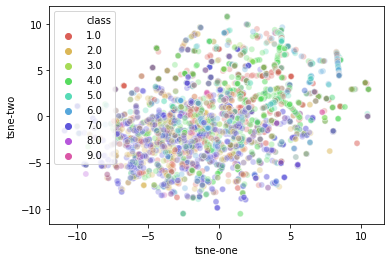

In [5]:
from mpl_toolkits.mplot3d import Axes3D

df_viz = pd.DataFrame()
df_viz['tsne-one'] = tsne_pca_results[:,0]
df_viz['tsne-two'] = tsne_pca_results[:,1]
df_viz['class'] = train_df['Class']
sns.scatterplot(x="tsne-one", y="tsne-two",
                hue="class",
                palette=sns.color_palette("hls", 9),
                data=df_viz,
                legend="full",
                alpha=0.3)
plt.show()

In [6]:
tsne_pca_results.shape

(3316, 3)

The classes are not at all well-separated! I would not expect our performance to be high, no matter what model we use

## A simple model

In [7]:
Text_INPUT_DIM=300

def baseline_model():
    model = Sequential()
    model.add(Dense(256, input_dim=Text_INPUT_DIM, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(9, activation="softmax"))
    
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)  
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

model = baseline_model()

In [8]:
estimator=model.fit(text_train_arrays, y_train_hot, validation_split=0.2, epochs=30, batch_size=64)

Epoch 1/30
42/42 [==============================] - 1s 14ms/step - loss: 2.0388 - accuracy: 0.2300 - val_loss: 1.8203 - val_accuracy: 0.2922
Epoch 2/30
42/42 [==============================] - 0s 3ms/step - loss: 1.6526 - accuracy: 0.3999 - val_loss: 1.7626 - val_accuracy: 0.3313
Epoch 3/30
42/42 [==============================] - 0s 3ms/step - loss: 1.5122 - accuracy: 0.4415 - val_loss: 1.6764 - val_accuracy: 0.3193
Epoch 4/30
42/42 [==============================] - 0s 3ms/step - loss: 1.4707 - accuracy: 0.4575 - val_loss: 1.7011 - val_accuracy: 0.3178
Epoch 5/30
42/42 [==============================] - 0s 3ms/step - loss: 1.4112 - accuracy: 0.4878 - val_loss: 1.6657 - val_accuracy: 0.3328
Epoch 6/30
42/42 [==============================] - 0s 3ms/step - loss: 1.3529 - accuracy: 0.4935 - val_loss: 1.6957 - val_accuracy: 0.3358
Epoch 7/30
42/42 [==============================] - 0s 3ms/step - loss: 1.2902 - accuracy: 0.5298 - val_loss: 1.6889 - val_accuracy: 0.3253
Epoch 8/30
42/42 [=

In [9]:
estimator.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [10]:
def plot_accuracy(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

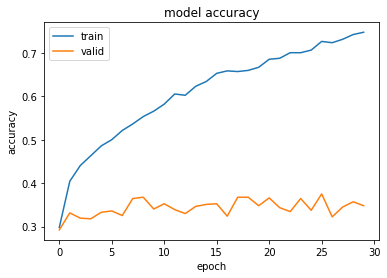

In [11]:
plot_accuracy(estimator)

In [12]:
def pred_and_decode(model, x_test):
    y_pred_prob = model.predict(x_test)
    y_pred_k1 = y_pred_prob.argmax(axis=-1)
    y_pred = label_encoder.inverse_transform(y_pred_k1)
    
    #pred_class = y_pred_k1
    #pred_class_df = pd.DataFrame({'ID':pred_ID, 'pred_class':pred_class})
    #merged_class_df = pd.merge(pred_class_df,desired_class_df,on='ID')
    #y_pred = merged_class_df.pred_class
    #y_true = merged_class_df.desired_class

    return list(y_pred),y_pred_prob

In [34]:
def assess_results(y_true,y_pred):
    # build confusion matrix
    confusion = pd.crosstab(pd.Series(y_true),pd.Series(y_pred),margins = False)
    sns.heatmap(confusion,annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Desired')
    plt.show()
    
    print(classification_report(y_true,y_pred))
    print('MCC:', matthews_corrcoef(y_true,y_pred))
    

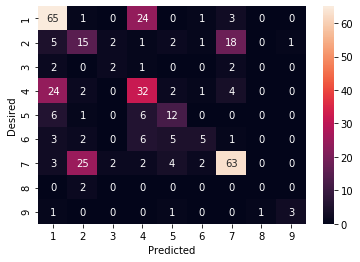

              precision    recall  f1-score   support

           1       0.60      0.69      0.64        94
           2       0.31      0.33      0.32        45
           3       0.33      0.29      0.31         7
           4       0.44      0.49      0.47        65
           5       0.46      0.48      0.47        25
           6       0.50      0.23      0.31        22
           7       0.69      0.62      0.66       101
           8       0.00      0.00      0.00         2
           9       0.75      0.50      0.60         6

    accuracy                           0.54       367
   macro avg       0.45      0.40      0.42       367
weighted avg       0.54      0.54      0.53       367

MCC: 0.4205504275456098


In [14]:
# assess results
y_pred,y_pred_prob = pred_and_decode(model, text_test_arrays)
assess_results(y_true,y_pred)

### ROC curves
Build ROC curves in a one-vs-all manner

In [15]:
# make ROC with these variables
print('model prediction output:', y_pred_prob.shape)
print('target label output:', y_true_oh.shape)

model prediction output: (367, 9)
target label output: (367, 9)


In [41]:
# put everything together into a function
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true,y_pred,title='ROC title',num_classes=9):
    # calculate ROC in a one-vs-all manner
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i],y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label='Class %i (area = %0.2f)' %(i+1,roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


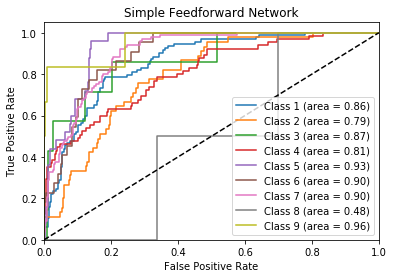

In [42]:
plot_roc(y_true_oh,model.predict(text_test_arrays),'Simple Feedforward Network')

This baseline model's validation accuracy is pretty bad, but its MCC and weighted-f1 score average are moderately better than Doc2Vec alone. Let's include gene and variation data into the training data.

## Using Gene & Variation data

In [23]:
from sklearn.decomposition import TruncatedSVD

Gene_INPUT_DIM=25
svd = TruncatedSVD(n_components=25, n_iter=Gene_INPUT_DIM, random_state=12)

# one-hot encode Gene and Variation Data
gene_hot_train = pd.get_dummies(train_df['Gene'])
truncated_gene_hot_train = svd.fit_transform(gene_hot_train.values)
var_hot_train = pd.get_dummies(train_df['Variation'])
truncated_var_hot_train = svd.fit_transform(var_hot_train.values)

gene_hot_test = pd.get_dummies(test_df_truncated['Gene'])
truncated_gene_hot_test = svd.fit_transform(gene_hot_test.values)
var_hot_test = pd.get_dummies(test_df_truncated['Variation'])
truncated_var_hot_test = svd.fit_transform(var_hot_test.values)

In [24]:
# combine Gene, Variation into encoded paragraph vectors array
X_train=np.hstack((truncated_gene_hot_train,truncated_var_hot_train,text_train_arrays))
X_test=np.hstack((truncated_gene_hot_test,truncated_var_hot_test,text_test_arrays))

In [25]:
# train the model once more
Text_INPUT_DIM=300

def baseline_model_big():
    model = Sequential()
    model.add(Dense(256, input_dim=Text_INPUT_DIM+Gene_INPUT_DIM*2, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(9, activation="softmax"))
    
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)  
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

model_big = baseline_model_big()

In [26]:
model_big.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               89856     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 80)                20560     
_________________________________________________________________
dense_7 (Dense)              (None, 9)                 729       
Total params: 176,937
Trainable params: 176,937
Non-trainable params: 0
________________________________________________

In [27]:
estimator2=model_big.fit(X_train, y_train_hot, validation_split=0.2, epochs=30, batch_size=64)

Epoch 1/30
42/42 [==============================] - 1s 6ms/step - loss: 2.0928 - accuracy: 0.2290 - val_loss: 1.7285 - val_accuracy: 0.3389
Epoch 2/30
42/42 [==============================] - 0s 3ms/step - loss: 1.6433 - accuracy: 0.4171 - val_loss: 1.7515 - val_accuracy: 0.2907
Epoch 3/30
42/42 [==============================] - 0s 3ms/step - loss: 1.5110 - accuracy: 0.4526 - val_loss: 1.6457 - val_accuracy: 0.3193
Epoch 4/30
42/42 [==============================] - 0s 3ms/step - loss: 1.4242 - accuracy: 0.4804 - val_loss: 1.6666 - val_accuracy: 0.3464
Epoch 5/30
42/42 [==============================] - 0s 3ms/step - loss: 1.3383 - accuracy: 0.5113 - val_loss: 1.5870 - val_accuracy: 0.3343
Epoch 6/30
42/42 [==============================] - 0s 3ms/step - loss: 1.3225 - accuracy: 0.4990 - val_loss: 1.5286 - val_accuracy: 0.3780
Epoch 7/30
42/42 [==============================] - 0s 3ms/step - loss: 1.2647 - accuracy: 0.5374 - val_loss: 1.6116 - val_accuracy: 0.3630
Epoch 8/30
42/42 [==

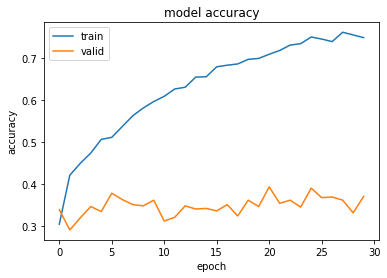

In [28]:
plot_accuracy(estimator2)

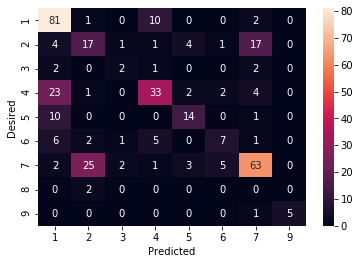

              precision    recall  f1-score   support

           1       0.63      0.86      0.73        94
           2       0.35      0.38      0.37        45
           3       0.33      0.29      0.31         7
           4       0.65      0.51      0.57        65
           5       0.61      0.56      0.58        25
           6       0.47      0.32      0.38        22
           7       0.69      0.62      0.66       101
           8       0.00      0.00      0.00         2
           9       1.00      0.83      0.91         6

    accuracy                           0.60       367
   macro avg       0.53      0.49      0.50       367
weighted avg       0.60      0.60      0.60       367

MCC: 0.5064097556583368


C:\Users\Kenny\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
y_pred,y_pred_prob = pred_and_decode(model_big, X_test)
assess_results(y_true,y_pred)

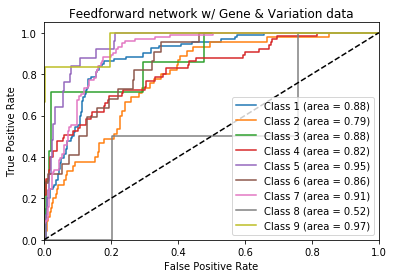

In [43]:
plot_roc(y_true_oh,y_pred_prob,'Feedforward network w/ Gene & Variation data')

The validation results seem equally bad, but the MCC and weighted f1 score seems to have improved marginally.

## Doc2Vec -> LSTMs
(inspiration: https://www.kaggle.com/viveksinghub/lstm-with-doc2vec)

In [44]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Flatten
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

In [45]:
# Build out our simple LSTM
embed_dim = 128
lstm_out = 196
num_words = 2000

# Model saving callback
ckpt_callback = ModelCheckpoint('keras_lstm_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

def lstm_model(c,training_weights):
    model = Sequential()
    #model.add(Embedding(num_words,embed_dim,input_length=c))
    model.add(LSTM(lstm_out, return_sequences=True, recurrent_dropout=0.2, dropout=0.2, input_shape=(1,c)))
    model.add(Dense(30,activation='relu'))
    model.add(Dense(9,activation='softmax'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['categorical_crossentropy','accuracy'])
    
    return model
    
model_lstm = lstm_model(X_train.shape[1],X_train)
print(model_lstm.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 196)            428848    
_________________________________________________________________
dense_8 (Dense)              (None, 1, 30)             5910      
_________________________________________________________________
dense_9 (Dense)              (None, 1, 9)              279       
Total params: 435,037
Trainable params: 435,037
Non-trainable params: 0
_________________________________________________________________
None


 not sure why there must be an extra dimension...

In [46]:
print(X_train.shape)
print(y_train_hot.shape)
print(train_df.shape)
y_train_hot

(3316, 350)
(3316, 9)
(3316, 8)


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [49]:
X_train_rs = np.reshape(X_train, (X_train.shape[0],1,X_train.shape[1]))
y_train_rs = np.reshape(y_train_hot, (y_train_hot.shape[0],1,y_train_hot.shape[1]))
X_train_rs.shape

(3316, 1, 350)

In [50]:
history_lstm = model_lstm.fit(X_train_rs,y_train_rs, validation_split=0.2, epochs=20)

Epoch 1/20
83/83 [==============================] - 2s 8ms/step - loss: 1.7975 - categorical_crossentropy: 1.7975 - accuracy: 0.3496 - val_loss: 1.6529 - val_categorical_crossentropy: 1.6529 - val_accuracy: 0.3283
Epoch 2/20
83/83 [==============================] - 0s 4ms/step - loss: 1.3169 - categorical_crossentropy: 1.3169 - accuracy: 0.5258 - val_loss: 1.6241 - val_categorical_crossentropy: 1.6241 - val_accuracy: 0.3554
Epoch 3/20
83/83 [==============================] - 0s 5ms/step - loss: 1.1151 - categorical_crossentropy: 1.1151 - accuracy: 0.5834 - val_loss: 1.7104 - val_categorical_crossentropy: 1.7104 - val_accuracy: 0.3539
Epoch 4/20
83/83 [==============================] - 0s 5ms/step - loss: 1.0095 - categorical_crossentropy: 1.0095 - accuracy: 0.6432 - val_loss: 1.5891 - val_categorical_crossentropy: 1.5891 - val_accuracy: 0.3886
Epoch 5/20
83/83 [==============================] - 0s 4ms/step - loss: 0.9108 - categorical_crossentropy: 0.9108 - accuracy: 0.6763 - val_loss:

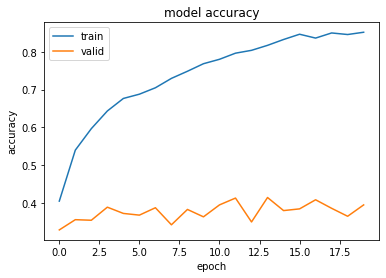

In [51]:
plot_accuracy(history_lstm)

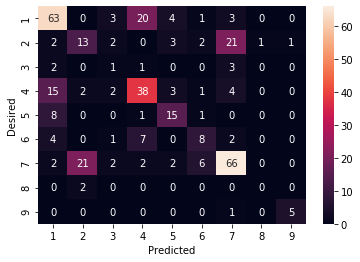

              precision    recall  f1-score   support

           1       0.66      0.67      0.66        94
           2       0.34      0.29      0.31        45
           3       0.09      0.14      0.11         7
           4       0.55      0.58      0.57        65
           5       0.56      0.60      0.58        25
           6       0.42      0.36      0.39        22
           7       0.66      0.65      0.66       101
           8       0.00      0.00      0.00         2
           9       0.83      0.83      0.83         6

    accuracy                           0.57       367
   macro avg       0.46      0.46      0.46       367
weighted avg       0.57      0.57      0.57       367

MCC: 0.46411146003641107


In [67]:
X_test_rs = np.reshape(X_test, (X_test.shape[0],1,X_test.shape[1]))

y_pred,y_pred_prob = pred_and_decode(model_lstm, X_test_rs)
assess_results(y_true,y_pred)

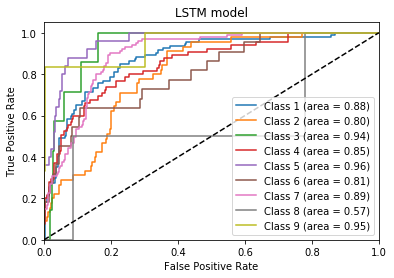

In [68]:
plot_roc(y_true_oh,y_pred_prob.squeeze(),'LSTM model')